### File Explanation

**trainRNN_HBTRC_EncoderModel_dropout.ipynb:**
<br> This notebook is to load HBTRC examples from 'preprocessData.pickle', create an "Encoder Network" and train the network with respect to a range of dropout rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model (function: **dynamicLSTM** using **length** in **trainRNN_network_utils.py**)
<br> 5) Create a single output by using the relevants outputs of encoder models of gene A and gene B 
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 8) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 9) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 10) Save them in "resultsEncoderDropout_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [35]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropouts = [0.4, 0.5, 0.6, 0.7, 0.8]                # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [37]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for dropout in dropouts:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM(rSnpRnaA_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastA = last_relevant(hidden_output_A, length(rSnpRnaA_pXNS))

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM(rSnpRnaB_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastB = last_relevant(hidden_output_B, length(rSnpRnaB_pXNS))

    last = tf.math.add(lastA, lastB)

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')  

    # Dense Layer
    logit = tf.layers.dense(last,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.3),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.nn.softmax( logit )
    
    l2 = lambda_l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC                   
                    })

                tst_loss, tst_acc, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, accuracy, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
    
        trainLosses[dropout] = train_losses
        testLosses[dropout] = test_losses
        trainAccuracy[dropout] = train_accuracies
        F1_scores[dropout] = test_f1_score
        print("Optimisation finished!")
        

Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1369836330413818: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1571298837661743: Accuracy = 0.567951315505272

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1024466753005981: Accuracy = 0.4333333373069763
Performance on test set: : Loss = 1.1549763679504395: Accuracy = 0.5482625405754094

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.096237063407898: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.1876140832901: Accuracy = 0.5491698745056927

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.07681405544281: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.14585542678833: Accuracy = 0.5539772793735291

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.1137055158615112: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.1535176038742065: Accuracy = 0.5535110434120335

Data shuffled. Epoch:

Performance on training data: Loss = 0.8619605302810669: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.0421441793441772: Accuracy = 0.7164135407166683

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.8660386204719543: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 1.0170981884002686: Accuracy = 0.7171863085094391

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.8274714946746826: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.041374921798706: Accuracy = 0.7175432909150152

Data shuffled. Epoch:  45
Performance on training data: Loss = 0.8612116575241089: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.0095107555389404: Accuracy = 0.718090595715314

Data shuffled. Epoch:  46
Performance on training data: Loss = 0.8093662858009338: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.0596116781234741: Accuracy = 0.7184933752355342

Data shuffled. Epoch:  47
Performance 

Performance on training data: Loss = 0.7754476070404053: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.0401030778884888: Accuracy = 0.7349830548610531

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.7848137021064758: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.0136897563934326: Accuracy = 0.7352507539037252

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.7999779582023621: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.038546085357666: Accuracy = 0.735562864697412

Data shuffled. Epoch:  87
Performance on training data: Loss = 0.7552535533905029: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.0359070301055908: Accuracy = 0.7359805450943468

Data shuffled. Epoch:  88
Performance on training data: Loss = 0.799105167388916: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 0.9958217144012451: Accuracy = 0.7362447219945526

Data shuffled. Epoch:  89
Performance o

Performance on training data: Loss = 0.7913504838943481: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.0468865633010864: Accuracy = 0.7449143187573591

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.7842531800270081: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.087082862854004: Accuracy = 0.7449266914768417

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.7288272380828857: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.0825653076171875: Accuracy = 0.7451587355094361

Data shuffled. Epoch:  129
Performance on training data: Loss = 0.7365469336509705: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 1.0607311725616455: Accuracy = 0.7451138578884252

Data shuffled. Epoch:  130
Performance on training data: Loss = 0.7634559869766235: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.0516177415847778: Accuracy = 0.7448954530283437

Data shuffled. Epoch:  131
Perfor

Performance on training data: Loss = 0.7038798928260803: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 1.077232837677002: Accuracy = 0.7528362137687667

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.7573204636573792: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.0321507453918457: Accuracy = 0.7531513495727118

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.7267391085624695: Accuracy = 0.846666693687439
Performance on test set: : Loss = 0.9932591915130615: Accuracy = 0.7534880856320931

Data shuffled. Epoch:  171
Performance on training data: Loss = 0.7320396900177002: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 0.9793392419815063: Accuracy = 0.7538377565577085

Data shuffled. Epoch:  172
Performance on training data: Loss = 0.7502962946891785: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.0047098398208618: Accuracy = 0.7541731237442121

Data shuffled. Epoch:  173
Perform

Performance on training data: Loss = 0.9777812957763672: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1847507953643799: Accuracy = 0.6228535675764402

Data shuffled. Epoch:  11
Performance on training data: Loss = 0.9437047243118286: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1517411470413208: Accuracy = 0.630878203212832

Data shuffled. Epoch:  12
Performance on training data: Loss = 0.9464507102966309: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.2011052370071411: Accuracy = 0.6359387437566433

Data shuffled. Epoch:  13
Performance on training data: Loss = 0.9639387130737305: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 1.1453980207443237: Accuracy = 0.6417266202419271

Data shuffled. Epoch:  14
Performance on training data: Loss = 0.9517359137535095: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 1.1025691032409668: Accuracy = 0.6471308953857433

Data shuffled. Epoch:  15
Performance

Performance on training data: Loss = 0.8173065781593323: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.0742632150650024: Accuracy = 0.6575808054471203

Data shuffled. Epoch:  53
Performance on training data: Loss = 0.8008463382720947: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.0644251108169556: Accuracy = 0.657779004724362

Data shuffled. Epoch:  54
Performance on training data: Loss = 0.8098354339599609: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.0477607250213623: Accuracy = 0.6589835602129002

Data shuffled. Epoch:  55
Performance on training data: Loss = 0.8224460482597351: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.104527473449707: Accuracy = 0.6594651386651048

Data shuffled. Epoch:  56
Performance on training data: Loss = 0.8185705542564392: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1003762483596802: Accuracy = 0.6589096559334

Data shuffled. Epoch:  57
Performance on t

Performance on training data: Loss = 0.76102215051651: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.0237157344818115: Accuracy = 0.6796549962973689

Data shuffled. Epoch:  95
Performance on training data: Loss = 0.7654311060905457: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.1031023263931274: Accuracy = 0.6800569097391155

Data shuffled. Epoch:  96
Performance on training data: Loss = 0.7418915629386902: Accuracy = 0.846666693687439
Performance on test set: : Loss = 1.021767497062683: Accuracy = 0.6803704631608164

Data shuffled. Epoch:  97
Performance on training data: Loss = 0.7882587313652039: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.061885118484497: Accuracy = 0.6811104196617053

Data shuffled. Epoch:  98
Performance on training data: Loss = 0.8099592924118042: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.0466240644454956: Accuracy = 0.6818503241624991

Data shuffled. Epoch:  99
Performance on t

Performance on training data: Loss = 0.7448954582214355: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.0725144147872925: Accuracy = 0.6950573159387671

Data shuffled. Epoch:  137
Performance on training data: Loss = 0.7037946581840515: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 1.0820331573486328: Accuracy = 0.6955606118628781

Data shuffled. Epoch:  138
Performance on training data: Loss = 0.7214444279670715: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.1556198596954346: Accuracy = 0.6958712464437667

Data shuffled. Epoch:  139
Performance on training data: Loss = 0.7650336027145386: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.0987035036087036: Accuracy = 0.6958516068481929

Data shuffled. Epoch:  140
Performance on training data: Loss = 0.7734418511390686: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1026591062545776: Accuracy = 0.696151090041466

Data shuffled. Epoch:  141
Perform

Performance on training data: Loss = 0.7433780431747437: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 1.1252862215042114: Accuracy = 0.698653476239047

Data shuffled. Epoch:  179
Performance on training data: Loss = 0.7164124846458435: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.1328295469284058: Accuracy = 0.6986356867981077

Data shuffled. Epoch:  180
Performance on training data: Loss = 0.7675110101699829: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.1039878129959106: Accuracy = 0.6986651446423031

Data shuffled. Epoch:  181
Performance on training data: Loss = 0.7578293681144714: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.1319513320922852: Accuracy = 0.6988532848359996

Data shuffled. Epoch:  182
Performance on training data: Loss = 0.7656160593032837: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.0793211460113525: Accuracy = 0.6988161588794056

Data shuffled. Epoch:  183
Perfor

Performance on training data: Loss = 0.9283338189125061: Accuracy = 0.5866666436195374
Performance on test set: : Loss = 1.1352441310882568: Accuracy = 0.389470293074603

Data shuffled. Epoch:  21
Performance on training data: Loss = 0.9054965376853943: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.1579312086105347: Accuracy = 0.38984099410313766

Data shuffled. Epoch:  22
Performance on training data: Loss = 0.9230598211288452: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1468440294265747: Accuracy = 0.39320628657988904

Data shuffled. Epoch:  23
Performance on training data: Loss = 0.9208329319953918: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1488739252090454: Accuracy = 0.3937814069192569

Data shuffled. Epoch:  24
Performance on training data: Loss = 0.9108270406723022: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.1276944875717163: Accuracy = 0.39551626458373235

Data shuffled. Epoch:  25
Performa

Performance on training data: Loss = 0.8306757211685181: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.0599913597106934: Accuracy = 0.485395327045015

Data shuffled. Epoch:  63
Performance on training data: Loss = 0.8120500445365906: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.064805269241333: Accuracy = 0.4874327012820336

Data shuffled. Epoch:  64
Performance on training data: Loss = 0.8405138254165649: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.0856677293777466: Accuracy = 0.4886970380598144

Data shuffled. Epoch:  65
Performance on training data: Loss = 0.8452552556991577: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.0387086868286133: Accuracy = 0.490770431029219

Data shuffled. Epoch:  66
Performance on training data: Loss = 0.8127250075340271: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.08367919921875: Accuracy = 0.49243025942105767

Data shuffled. Epoch:  67
Performance on 

Performance on training data: Loss = 0.780021607875824: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1039881706237793: Accuracy = 0.5272772329149692

Data shuffled. Epoch:  105
Performance on training data: Loss = 0.7400971055030823: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.1162372827529907: Accuracy = 0.5277635994664024

Data shuffled. Epoch:  106
Performance on training data: Loss = 0.7557590007781982: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.1406395435333252: Accuracy = 0.5281381407468195

Data shuffled. Epoch:  107
Performance on training data: Loss = 0.7760833501815796: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.125259518623352: Accuracy = 0.5281722133007107

Data shuffled. Epoch:  108
Performance on training data: Loss = 0.7994504570960999: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.097084879875183: Accuracy = 0.5283356282452103

Data shuffled. Epoch:  109
Performanc

Performance on training data: Loss = 0.733782172203064: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.1733869314193726: Accuracy = 0.5312819646393703

Data shuffled. Epoch:  147
Performance on training data: Loss = 0.7673705220222473: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.1120504140853882: Accuracy = 0.5310769660851112

Data shuffled. Epoch:  148
Performance on training data: Loss = 0.7708781957626343: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.1903622150421143: Accuracy = 0.5312637153314275

Data shuffled. Epoch:  149
Performance on training data: Loss = 0.7904621958732605: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.0845351219177246: Accuracy = 0.5313685242312142

Data shuffled. Epoch:  150
Performance on training data: Loss = 0.7555952072143555: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.144223928451538: Accuracy = 0.5316240084321348

Data shuffled. Epoch:  151
Perform

Performance on training data: Loss = 0.719971776008606: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.2062289714813232: Accuracy = 0.5307380122697192

Data shuffled. Epoch:  189
Performance on training data: Loss = 0.7589762210845947: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.1058083772659302: Accuracy = 0.5307045729722027

Data shuffled. Epoch:  190
Performance on training data: Loss = 0.712236762046814: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 1.1787089109420776: Accuracy = 0.530488726261921

Data shuffled. Epoch:  191
Performance on training data: Loss = 0.7303594946861267: Accuracy = 0.846666693687439
Performance on test set: : Loss = 1.1237848997116089: Accuracy = 0.5306298988102028

Data shuffled. Epoch:  192
Performance on training data: Loss = 0.7581427097320557: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.1600223779678345: Accuracy = 0.5311271906235276

Data shuffled. Epoch:  193
Performan

Performance on training data: Loss = 0.865015983581543: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.1372065544128418: Accuracy = 0.6012938711541599

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.8857181668281555: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1594700813293457: Accuracy = 0.5992888888714435

Data shuffled. Epoch:  32
Performance on training data: Loss = 0.8855215311050415: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.101963996887207: Accuracy = 0.5971521288076965

Data shuffled. Epoch:  33
Performance on training data: Loss = 0.8673043847084045: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.0913755893707275: Accuracy = 0.5959210660557333

Data shuffled. Epoch:  34
Performance on training data: Loss = 0.874856173992157: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.139994502067566: Accuracy = 0.595792763214886

Data shuffled. Epoch:  35
Performance on 

Performance on training data: Loss = 0.8422489762306213: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.061463475227356: Accuracy = 0.6008794452176417

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.8398502469062805: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.1017593145370483: Accuracy = 0.6004794863666465

Data shuffled. Epoch:  74
Performance on training data: Loss = 0.7934269309043884: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.0969620943069458: Accuracy = 0.6001210265772674

Data shuffled. Epoch:  75
Performance on training data: Loss = 0.8205674886703491: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.0841965675354004: Accuracy = 0.6001767675725689

Data shuffled. Epoch:  76
Performance on training data: Loss = 0.8238914608955383: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.0909569263458252: Accuracy = 0.6004056437254479

Data shuffled. Epoch:  77
Performance 

Performance on training data: Loss = 0.7804895639419556: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 0.9937414526939392: Accuracy = 0.5935442831053043

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.7823783755302429: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.0977479219436646: Accuracy = 0.593659737255716

Data shuffled. Epoch:  116
Performance on training data: Loss = 0.8465859889984131: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.0454190969467163: Accuracy = 0.5937922852728147

Data shuffled. Epoch:  117
Performance on training data: Loss = 0.7767359018325806: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.0359693765640259: Accuracy = 0.5937752725854464

Data shuffled. Epoch:  118
Performance on training data: Loss = 0.8165431618690491: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.1034867763519287: Accuracy = 0.5935496886786392

Data shuffled. Epoch:  119
Perfor

Performance on training data: Loss = 0.7479714155197144: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.0509791374206543: Accuracy = 0.5927196729751664

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.8197215795516968: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.0420559644699097: Accuracy = 0.5931064637272881

Data shuffled. Epoch:  158
Performance on training data: Loss = 0.7944870591163635: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.0757900476455688: Accuracy = 0.5933065209781824

Data shuffled. Epoch:  159
Performance on training data: Loss = 0.7179844379425049: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 1.0142266750335693: Accuracy = 0.5934003773779478

Data shuffled. Epoch:  160
Performance on training data: Loss = 0.8151527047157288: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.1370084285736084: Accuracy = 0.593632962178758

Data shuffled. Epoch:  161
Perform

Performance on training data: Loss = 0.7730370163917542: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.0551539659500122: Accuracy = 0.6047051432985421

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.7607395648956299: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.025478482246399: Accuracy = 0.6050074173211472

Optimisation finished!
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.160386323928833: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.1753976345062256: Accuracy = 0.6240309826317662

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.151808500289917: Accuracy = 0.36666667461395264
Performance on test set: : Loss = 1.199131727218628: Accuracy = 0.6091845964439159

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.182716727256775: Accuracy = 0.3466666638851166
Performance on test set: : Loss = 1.236234426498413: Accuracy = 0.6131387197214637

Data shuffled. Epoch

Performance on training data: Loss = 0.9121983647346497: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.1208045482635498: Accuracy = 0.5429799080486905

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.890438973903656: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.1256568431854248: Accuracy = 0.5459711203640351

Data shuffled. Epoch:  42
Performance on training data: Loss = 0.9148061275482178: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.0876621007919312: Accuracy = 0.549089120316798

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.9378795623779297: Accuracy = 0.6133333444595337
Performance on test set: : Loss = 1.0572458505630493: Accuracy = 0.5530934129110927

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.8972843289375305: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.05141019821167: Accuracy = 0.5569685580234176

Data shuffled. Epoch:  45
Performance on

Performance on training data: Loss = 0.8426992893218994: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.0732429027557373: Accuracy = 0.6005354042910152

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.8352938890457153: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.1171830892562866: Accuracy = 0.6007407124344687

Data shuffled. Epoch:  84
Performance on training data: Loss = 0.8951495289802551: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.0984578132629395: Accuracy = 0.6007594393053128

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.819963812828064: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.0804977416992188: Accuracy = 0.601150876847043

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.82481849193573: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.0568782091140747: Accuracy = 0.6016712229789949

Data shuffled. Epoch:  87
Performance on 

Performance on training data: Loss = 0.8223789930343628: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.0598326921463013: Accuracy = 0.6032692055412081

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.7977939248085022: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.124266505241394: Accuracy = 0.6030148681973807

Data shuffled. Epoch:  126
Performance on training data: Loss = 0.8189477920532227: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.0481733083724976: Accuracy = 0.6026808645240621

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.8331241607666016: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.122773289680481: Accuracy = 0.6025509176762968

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.8038931488990784: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.0573556423187256: Accuracy = 0.6025660608643397

Data shuffled. Epoch:  129
Performa

Performance on training data: Loss = 0.8453711867332458: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.04268217086792: Accuracy = 0.6055424056518696

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.8291168212890625: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.0521234273910522: Accuracy = 0.6054153043465701

Data shuffled. Epoch:  168
Performance on training data: Loss = 0.8194782733917236: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1214839220046997: Accuracy = 0.6052890422064886

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.7557963728904724: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.0323796272277832: Accuracy = 0.6050222207561854

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.8110741376876831: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.1140695810317993: Accuracy = 0.6049900616602882

Data shuffled. Epoch:  171
Perform

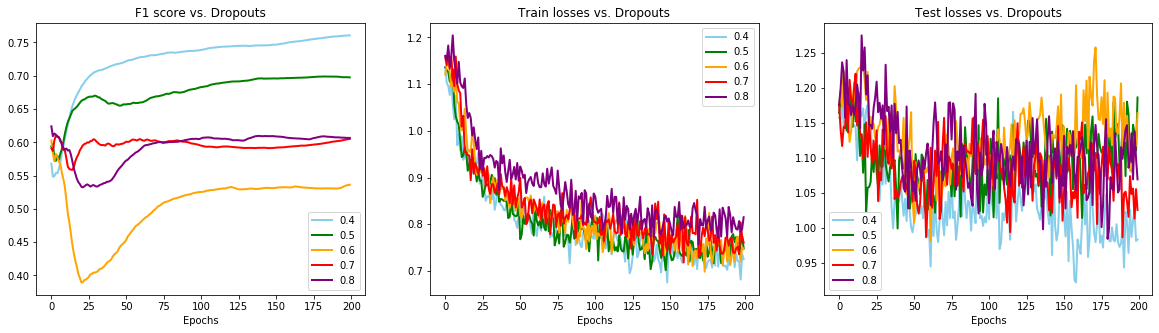

In [47]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Dropouts")

In [51]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsEncoderDropout_HBTRC.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
